# Blind injection study 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
# read data
data = pd.read_csv("data.txt", sep = ",")
data.columns = data.columns.str.strip()

In [3]:
data.head()

,x,y1,y2,y3
0,-10.00000,-27.835948,-1.204022,32.752084
1,-9.97998,-29.139783,-2.574528,31.335606
2,-9.95996,-28.501142,-2.001794,31.858014
3,-9.93994,-27.178927,-0.744721,33.060393
4,-9.91992,-27.492202,-1.122373,32.623676


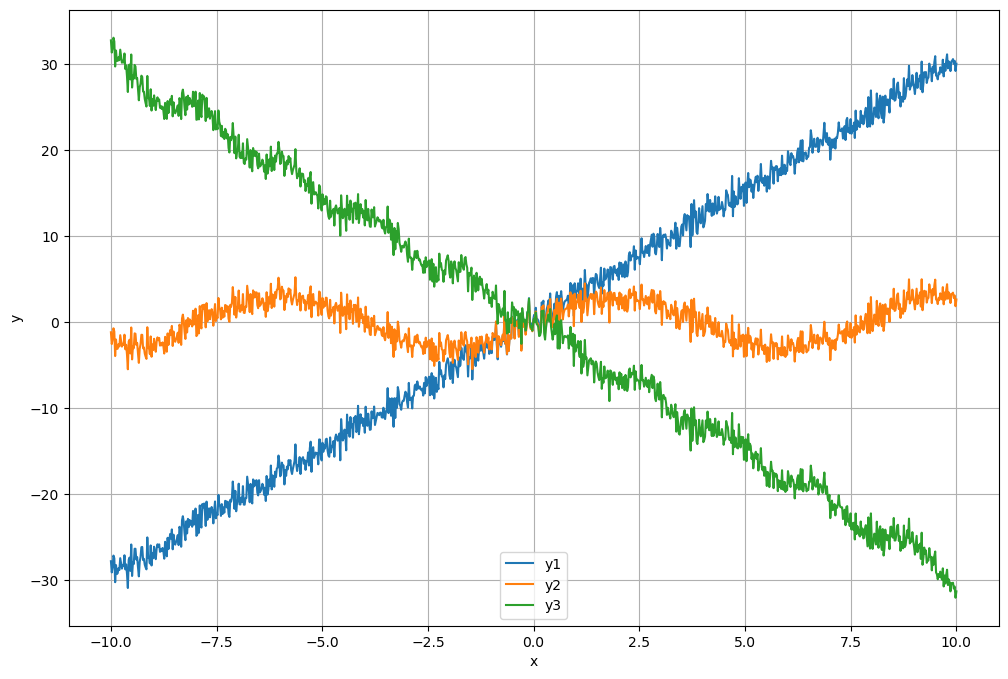

In [4]:
# plot data
plt.figure(figsize=(12, 8))
plt.plot(data['x'], data['y1'], label='y1')
plt.plot(data['x'], data['y2'], label='y2')
plt.plot(data['x'], data['y3'], label='y3')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

The statistical model is y ~ $N(f(x,\beta ),1)$ that each y is normally distributed with the mean of $f(x,\beta )$ and variance of 1. i.e., For i=,...,n,  $y_i  =f(x_i,\beta ) + e_i , e_i$ ~ N(0,1) 


## y1

It can be seen from the image of y1 that y1 has both a linear growth trend and an oscillation trend.
So we can first assume that the model of y1 is $y_1 = \beta_0 + \beta_1*x + \beta_2 sin(\omega *x) + e$

$\beta_0$ - intercept

$\beta_1$ - slope

$\beta_2$ - amplitude

$\omega$ - oscillation frequency

$e$ - Errors, $e$ ~ N(0,1)

In [87]:
def model(x, beta0, beta1, beta2, omega):
    return beta0 + beta1 * x + beta2 * np.sin(omega * x)


In [88]:
def log_likelihood(y_obs, y_pred, sigma=1):
    return -0.5 * np.sum(((y_obs - y_pred) / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))


In [89]:
def prior(beta0, beta1, beta2, omega):
    if 0 < omega < 20 and -10 < beta0 < 10 and -10 < beta1 < 10 and -10 < beta2 < 10:
        return 1
    else:
        return 0


In [102]:
def metropolis_hastings(y, x, iterations, initial_params, step_size):
    beta0, beta1, beta2, omega = initial_params
    current_log_prob = log_likelihood(y, model(x, beta0, beta1, beta2, omega)) + np.log(prior(beta0, beta1, beta2, omega))
    
    chain = np.empty((iterations, len(initial_params)))
    chain[0] = initial_params
    
    for i in range(1, iterations):
        beta0_prop, beta1_prop, beta2_prop, omega_prop = chain[i-1] + step_size * np.random.randn(4)
        prop_log_prob = log_likelihood(y, model(x, beta0_prop, beta1_prop, beta2_prop, omega_prop)) + np.log(prior(beta0_prop, beta1_prop, beta2_prop, omega_prop))
        
        # 计算接受概率，使用对数形式避免直接除法
        if prop_log_prob - current_log_prob > np.log(np.random.rand()):
            chain[i] = [beta0_prop, beta1_prop, beta2_prop, omega_prop]
            current_log_prob = prop_log_prob
        else:
            # 如果提议被拒绝，使用当前参数作为链中的下一个样本
            chain[i] = chain[i-1]
    
    return chain



In [103]:
#
initial_params = [0, 3, 1, 10]  
iterations = 10000  #
step_size = 0.01  

accepted = metropolis_hastings(data['y1'], data['x'], iterations, initial_params, step_size)




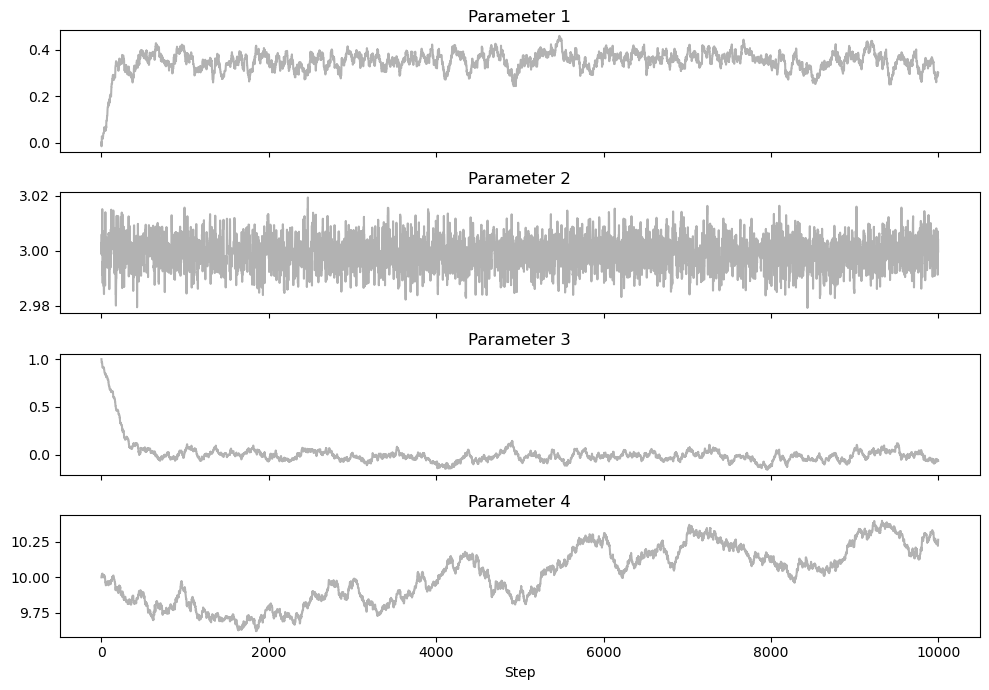

In [104]:
n_params = accepted.shape[1]

fig, axes = plt.subplots(n_params, figsize=(10, 7), sharex=True)
for i in range(n_params):
    axes[i].plot(accepted[:, i], "k", alpha=0.3)
    axes[i].set_title(f'Parameter {i+1}')
axes[n_params-1].set_xlabel("Step")
plt.tight_layout()
plt.show()

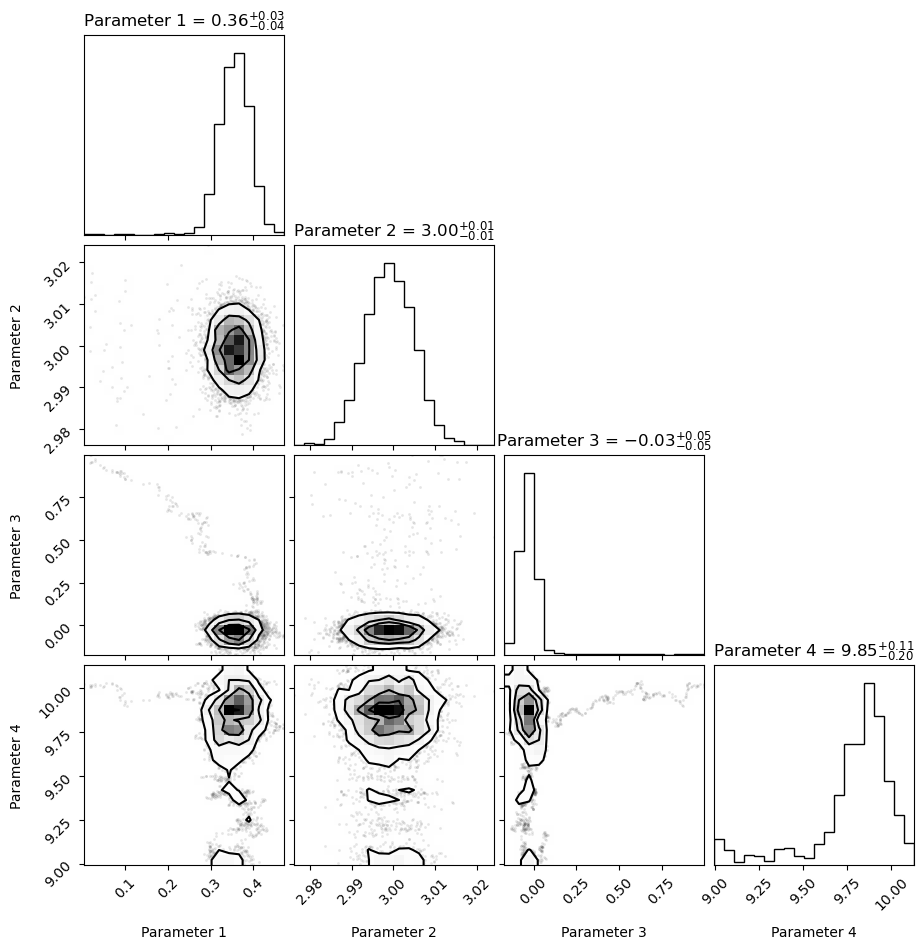

In [97]:
import corner
import matplotlib.pyplot as plt


fig = corner.corner(accepted, labels=[f'Parameter {i+1}' for i in range(accepted.shape[1])], 
                    show_titles=True, title_kwargs={"fontsize": 12})

plt.show()


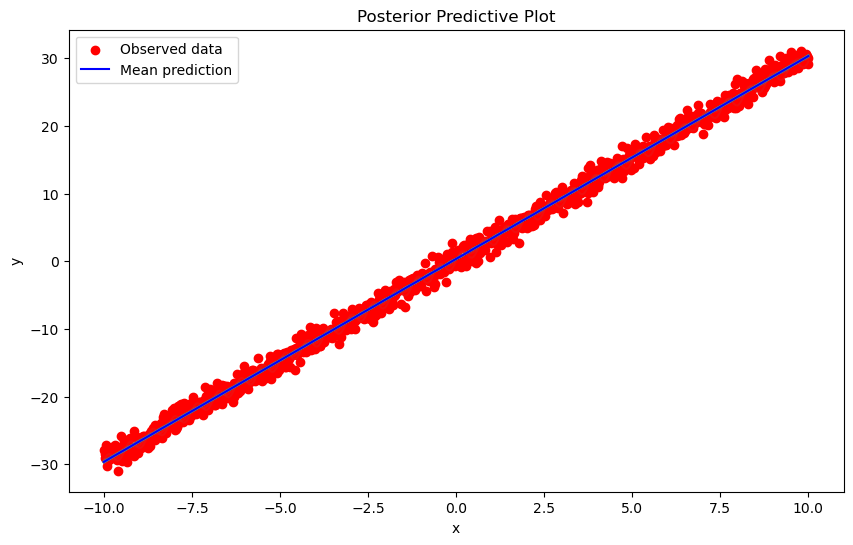

In [99]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

plt.scatter(data['x'], data['y1'], color='r', label='Observed data')


for beta0, beta1, beta2, omega in accepted[np.random.randint(len(accepted), size=100)]:
    
    y_pred = model(data['x'], beta0, beta1, beta2, omega)
    plt.plot(data['x'], y_pred, color='grey', alpha=0.1)

y_pred_mean = np.mean([model(data['x'], *params) for params in accepted], axis=0)
plt.plot(data['x'], y_pred_mean, color='blue', label='Mean prediction')

plt.title('Posterior Predictive Plot')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [105]:
def run_mcmc(y, x, n_iterations, n_walkers, step_size, initial_params_range):
    # 存储所有walkers的链
    chains = np.empty((n_walkers, n_iterations, len(initial_params_range)))
    
    # 对每个walker初始化参数，并运行MCMC
    for w in range(n_walkers):
        # 从指定的范围中为每个参数随机选择一个初始值
        initial_params = [np.random.uniform(low, high) for low, high in initial_params_range]
        
        # 运行Metropolis-Hastings算法
        chain = metropolis_hastings(y, x, n_iterations, initial_params, step_size)
        
        # 将结果存储在chains数组中
        chains[w, :, :] = chain
    
    return chains

# 设置walkers的数量和初始参数范围
n_walkers = 10
initial_params_range = [(0, 1), (1, 3), (0, 2), (5, 15)]  # 每个参数的(low, high)范围

# 运行MCMC
chains = run_mcmc(data['y1'], data['x'], 5000, n_walkers, 0.01, initial_params_range)

# 处理chains得到结果...


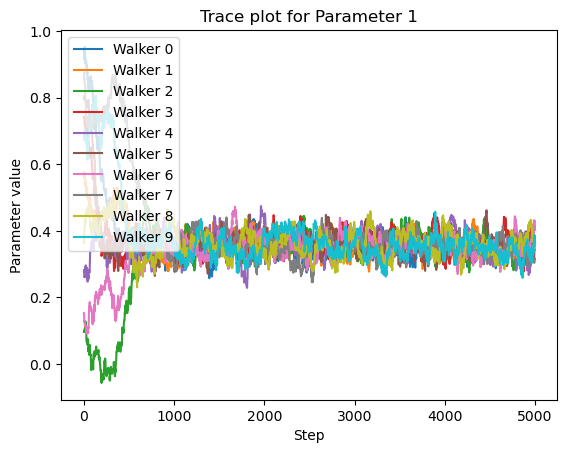

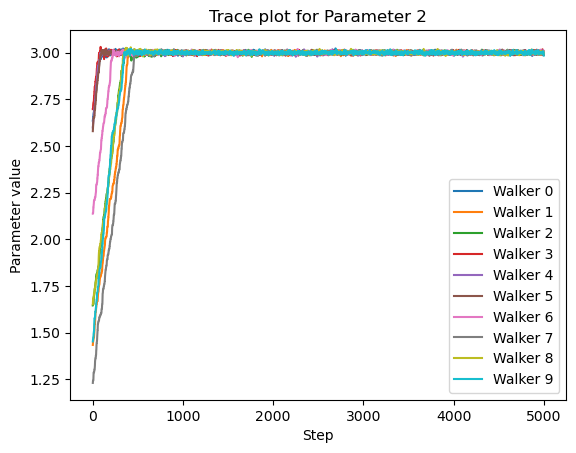

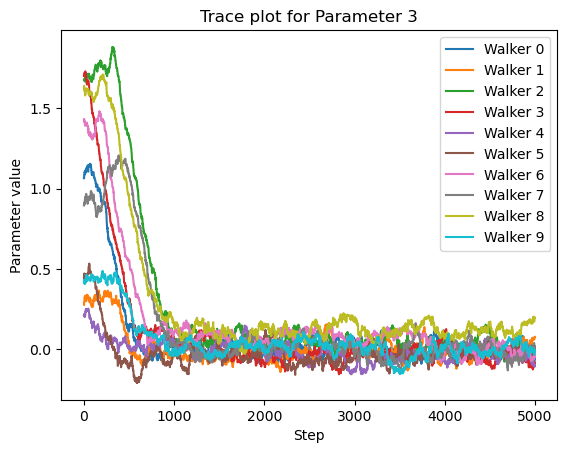

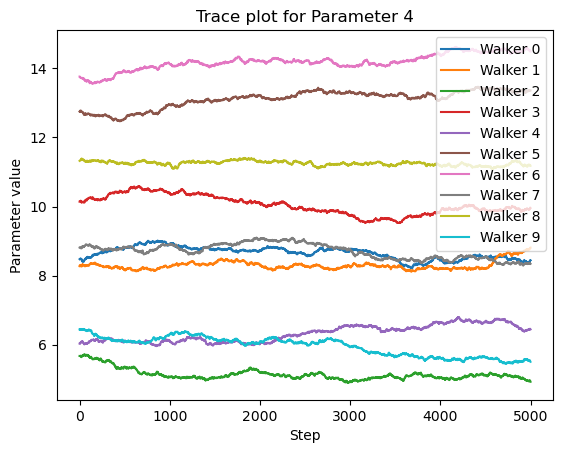

In [118]:
import matplotlib.pyplot as plt

for id in range(4):
    param_id = id  
    for i in range(n_walkers):
        plt.plot(chains[i, :, param_id], label=f'Walker {i}')
    plt.title(f'Trace plot for Parameter {param_id+1}')
    plt.xlabel('Step')
    plt.ylabel('Parameter value')
    plt.legend()
    plt.show()


0
1
2
3
